In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

print("OpenCV version: " + cv2.__version__)

OpenCV version: 4.11.0


Cropped Image by horizontal 20.0% - 80.0% and vertical 15.0% - 75.0%


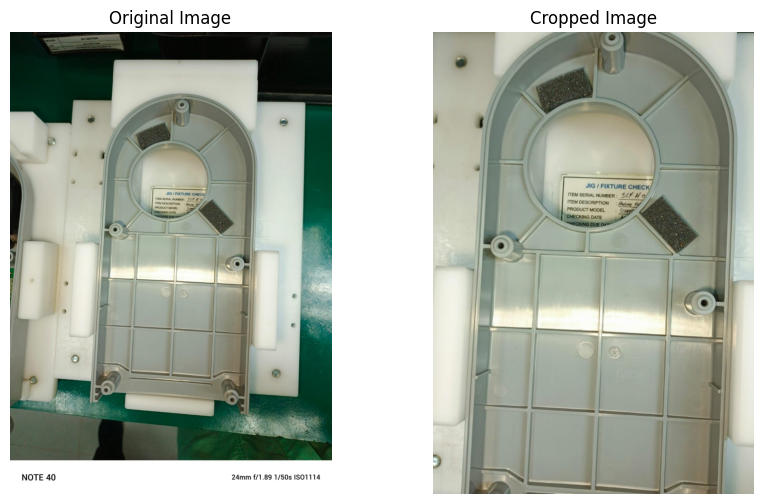

In [40]:
# Load the image
original_img = cv2.imread("object_ok.jpeg")  # Replace with your image file

# Get the image dimensions
h, w, __ = original_img.shape

# Crop the image

crop_x0 = 0.2 #`20% padding from left`
crop_xt = 0.8 #`20% padding from right`
crop_y0 = 0.15 #`15% padding from top`
crop_yt = 0.75 #`25% padding from bottom`

print(f"Cropped Image by horizontal {crop_x0*100}% - {crop_xt*100}% and vertical {crop_y0*100}% - {crop_yt*100}%")

img = original_img[int(h * crop_y0) : int(h * crop_yt), int(w * crop_x0) : int(w * crop_xt)]


# display the image
plt.figure(figsize=(10,6))

plt.subplot(1, 2, 1)
plt.imshow(original_img[:,:,::-1])
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img[:,:,::-1])
plt.title("Cropped Image")
plt.axis("off")

plt.show()


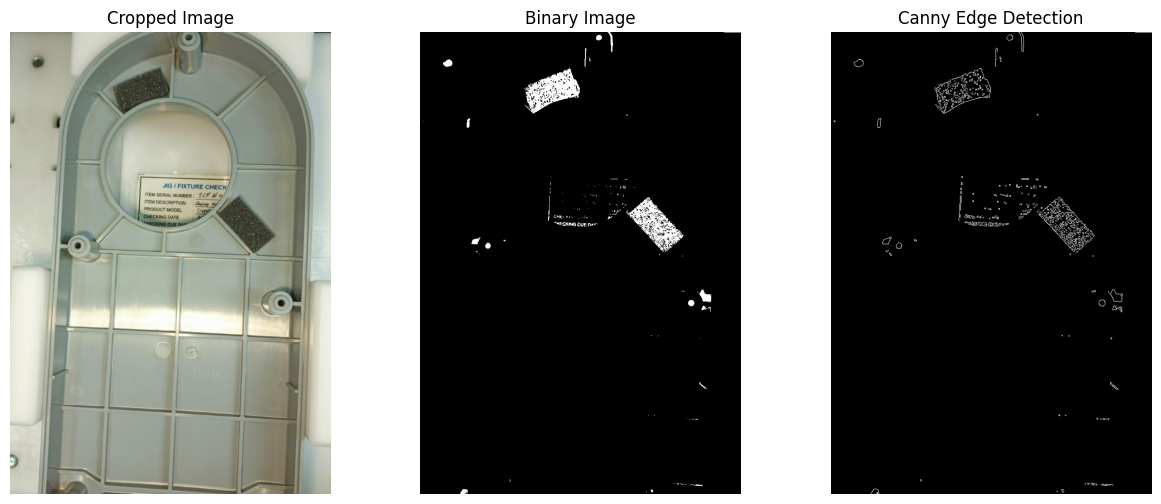

In [48]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Step 1: Apply simple Binary Thresholding
_, binary = cv2.threshold(gray, 70, 255, cv2.THRESH_BINARY_INV)

# Step 2: Apply Canny Edge Detection
edges = cv2.Canny(binary, 100, 200)

# Show result images
plt.figure(figsize=(15,6))

plt.subplot(1, 3, 1)
plt.imshow(img[:,:,::-1])
plt.title("Cropped Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(binary, cmap="gray")
plt.title("Binary Image")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edge Detection")
plt.axis("off")

plt.show()

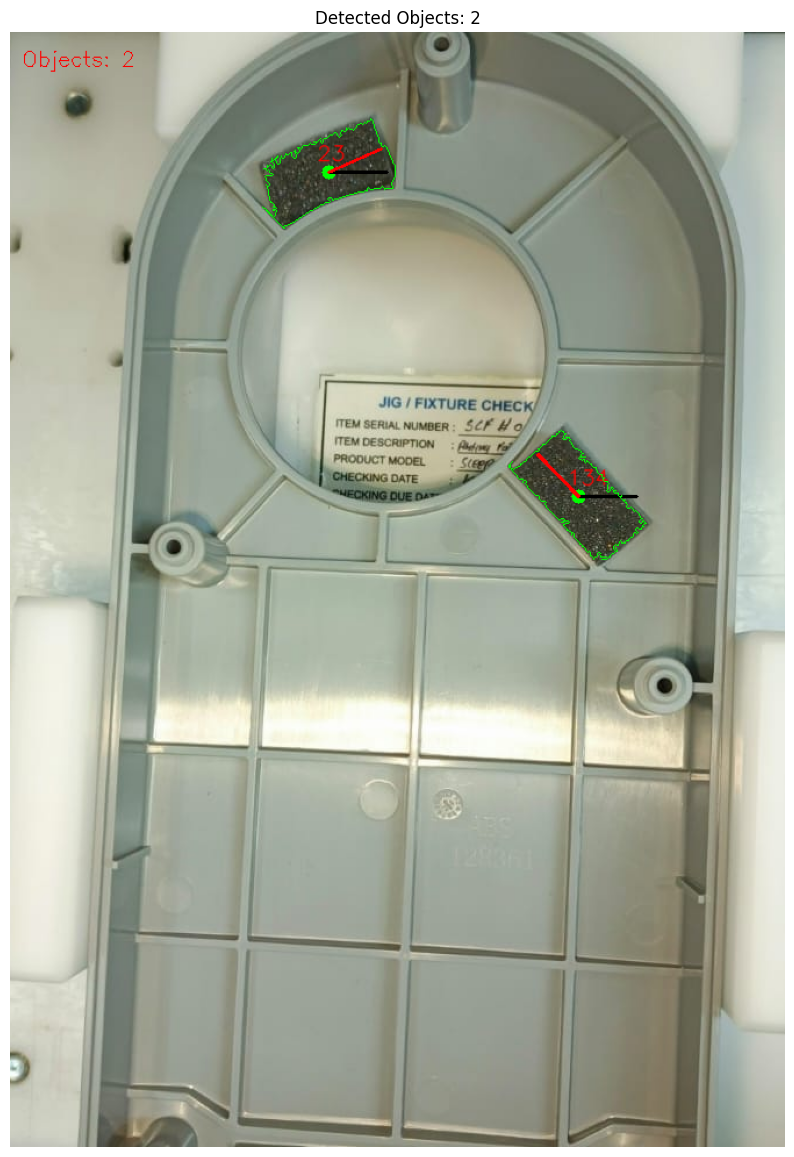

In [64]:
# Step 3: Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Step 4: Calculate centroids & Draw contours
num_objects = 0
output = img.copy()
_h, _w, __ = img.shape
for contour in contours:

    # Skip small contours less than 0.25% of the image area
    if cv2.contourArea(contour) < (_h*_w*0.0025) :  
        continue

    # -------------------------------------------------------------------------------------------------------- #
    #                                       calculate moments for each contour                                 #
    # -------------------------------------------------------------------------------------------------------- #
    M = cv2.moments(contour)
    cx = int(M["m10"] / M["m00"])
    cy = int(M["m01"] / M["m00"])
    center = (cx, cy)

    # Draw centroid
    cv2.circle(output, (cx, cy), 6, (0, 255, 0), -1)
    # -------------------------------------------------------------------------------------------------------- #
    #                                   end calculate moments for each contour                                 #
    # -------------------------------------------------------------------------------------------------------- #




    # -------------------------------------------------------------------------------------------------------- #
    #                                       calculate PCA of the contour                                       #
    # -------------------------------------------------------------------------------------------------------- #
    data_points = np.array(contour.squeeze(), dtype=np.float64)
    mean, eigenvectors = cv2.PCACompute(data_points, mean=None)

    # eigenvectors[0, 0] is the x-component of the first eigenvector
    # eigenvectors[0, 1] is the y-component of the first eigenvector
    # Computes the angle (θ) of the principal axis with respect to the x-axis.
    angle_rad_original = np.arctan2(eigenvectors[0, 1], eigenvectors[0, 0]) # in radians within the range [-π, π]
    angle_rad = (angle_rad_original - np.pi) % (-1 * np.pi) # in radians within the range [0, π]
    angle_rad = abs(angle_rad) # Convert to range [0, π]

    # Define the length of the orientation lines
    length = 50

    # Black line for original orientation, always referenced as horizontal line
    cv2.line(output, center, (center[0] + length, center[1]), (0, 0, 0), 2)  

    # Compute the end point for the **rotation axis** (red line)
    end_x = int(center[0] + length * np.cos(angle_rad)) # x = x0 + r * cos(angle)
    end_y = int(center[1] - length * np.sin(angle_rad)) # y = y0 - r * sin(angle)
    cv2.line(output, center, (end_x, end_y), (0, 0, 255), 2)  # Red line for rotation axis

    # Draw angle text near the red line
    angle = np.rad2deg(angle_rad) # in degrees within the range [0, 180]
    text_position = (center[0] - 10, center[1] - 10)
    cv2.putText(output, f"{int(angle)}", text_position, cv2.FONT_HERSHEY_SIMPLEX, 
                0.6, (0, 0, 255), 1, cv2.LINE_AA)
    # -------------------------------------------------------------------------------------------------------- #
    #                                   End calculate PCA of the contour                                       #
    # -------------------------------------------------------------------------------------------------------- #


    # Increment the number of objects detected
    num_objects += 1

    # Draw contours
    cv2.drawContours(output, [contour], -1, (0, 255, 0), 1)



    
# Step 5: Display the number of objects detected # Number of objects detected based on the number of contours
cv2.putText(output, f"Objects: {num_objects}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
            0.6, (0, 0, 255), 1)




# Display detected objects
plt.figure(figsize=(10,15))

plt.imshow(output[:,:,::-1])
plt.title(f"Detected Objects: {num_objects}")
plt.axis("off")

plt.show()
